# Trabalho Final Data Mining

*Turma Bi Master 2019.3*

**Professora**: Manoela Kohler

**Aluno**: Rodrigo Moreira Araújo

**Matrícula**: 192.190.075

## Descrição do problema

**Problema de classificação**

* 27 atributos numéricos e categóricos que descrevem o estado de saúde de cavalos; 
* Três classes de saída que indicam o que aconteceu com o cavalo: morreu, viveu ou se foi submetido à eutanásia. A ideia é prever se um cavalo pode sobreviver ou não baseado nas condições médicas passadas.

## Análise exploratória dos dados

#### 1. Importação dos módulos necessários

In [92]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### 2. Criação dos DataFrames de treino (df) e  teste (df_test)

In [133]:
# Criação dos DataFrames de treino e teste

df = pd.read_csv("horse.csv")
df_test = pd.read_csv("horseTest.csv")

df.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,...,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,...,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,...,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,...,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,...,74.0,7.4,NaN,NaN,died,no,4300,0,0,no


#### 3. Verificação de valores faltantes (*missing values*)

In [134]:
# Extrai o número total de linhas do Dataframe
total_lines = df.shape[0]

# Avalia o número de linhas preenchidas por coluna
cols_count = df.count(axis=0)

# Seleciona apenas as colunas com dados faltantes
missing_cols = cols_count[cols_count != total_lines]

# Verifica o tipo das colunas com dados faltantes
col_types = df[missing_cols.index].dtypes

# Segrega as colunas de float e de string
float_cols = col_types[col_types == "float64"]
str_cols = col_types[col_types == "object"]

##### 3.1. Preenchimento dos valores faltantes das colunas categóricas

In [144]:
# Extrai a moda de cada uma das colunas de string com valores faltantes
col_modes = df[str_cols.index].mode()
# df[col_modes.columns].fillna(col_modes.iloc[0], axis=0)
df[col_modes.columns] = df[col_modes.columns].fillna(col_modes.iloc[0], axis=0)
df[col_modes.columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 12 columns):
temp_of_extremities      299 non-null object
peripheral_pulse         299 non-null object
mucous_membrane          299 non-null object
capillary_refill_time    299 non-null object
pain                     299 non-null object
peristalsis              299 non-null object
abdominal_distention     299 non-null object
nasogastric_tube         299 non-null object
nasogastric_reflux       299 non-null object
rectal_exam_feces        299 non-null object
abdomen                  299 non-null object
abdomo_appearance        299 non-null object
dtypes: object(12)
memory usage: 28.1+ KB


##### 3.2 Preenchimento dos valores faltantes das colunas numéricas

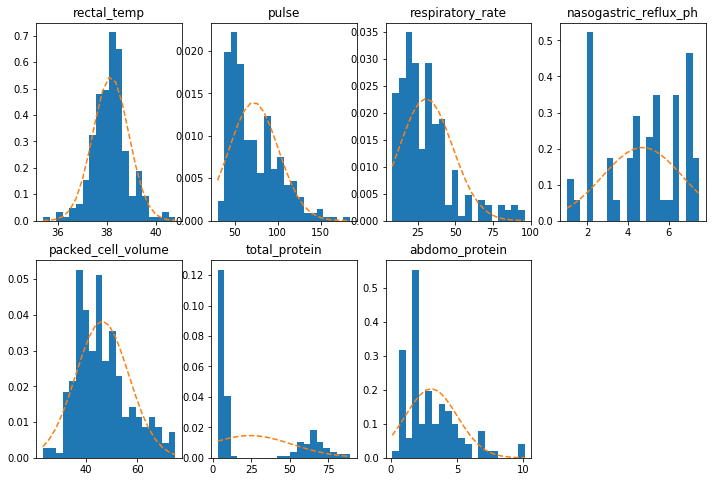

In [136]:
# Análise das distribuições dos valores faltantes do tipo float
def plot_histograms(dataframe, cols):
    fig = plt.figure(figsize=(12,8))
    for i, col in enumerate(cols.index):
        plt.subplot(2, 4, i+1)
        plt.title(col)
        vals = np.array(dataframe[col].copy().dropna().values)
        # Plota o histograma
        nhist, bins, patches = plt.hist(vals, bins=20, density=True)
        # Cálculo dos parâmetros da distribuição normal
        mean = vals.mean() 
        std = vals.std()  
        y = ((1/(np.sqrt(2*np.pi)*std))*np.exp(-0.5*(1/std*(bins-mean))**2))
        # Plota a gaussiana que melhor ajusta o histograma
        plt.plot(bins, y, '--')

plot_histograms(df, float_cols)

A análise dos histogramas permite concluir que as colunas `rectal_temp`, `packed_cell_volume`, `pulse` e `respiratory_rate` se aproximam razoavelmente de distribuições normais. Assim, os valores faltantes podem ser preenchidos com a mediana.

Para as outras três colunas (`nasograstric_reflux_ph`, `total_protein`, `abdomo_protein`), será usada a moda.

In [143]:
normal_float_cols = ["rectal_temp","packed_cell_volume","pulse","respiratory_rate"]
other_float_cols = ["nasogastric_reflux_ph", "total_protein", "abdomo_protein"]
for col in normal_float_cols:
    df[col] = df[col].fillna(df[col].median())
for col in other_float_cols:
    df[col] = df[col].fillna(df[col].mode())

df[float_cols.index].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 7 columns):
rectal_temp              299 non-null float64
pulse                    299 non-null float64
respiratory_rate         299 non-null float64
nasogastric_reflux_ph    299 non-null float64
packed_cell_volume       299 non-null float64
total_protein            299 non-null float64
abdomo_protein           299 non-null float64
dtypes: float64(7)
memory usage: 16.4 KB


In [154]:
# Confirmando que todo o dataframe encontra-se preenchido
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 28 columns):
surgery                  299 non-null object
age                      299 non-null object
hospital_number          299 non-null int64
rectal_temp              299 non-null float64
pulse                    299 non-null float64
respiratory_rate         299 non-null float64
temp_of_extremities      299 non-null object
peripheral_pulse         299 non-null object
mucous_membrane          299 non-null object
capillary_refill_time    299 non-null object
pain                     299 non-null object
peristalsis              299 non-null object
abdominal_distention     299 non-null object
nasogastric_tube         299 non-null object
nasogastric_reflux       299 non-null object
nasogastric_reflux_ph    299 non-null float64
rectal_exam_feces        299 non-null object
abdomen                  299 non-null object
packed_cell_volume       299 non-null float64
total_protein            299 non-nul